In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from pdb import *
from pathlib import Path
from skimage.io import imread

In [2]:
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.vision.all import *
# from PIL import Images

In [3]:
from nuclei import *

In [4]:
DATA_PATH =  Path('../data/datasciencebowl')
TRAIN_PATH = DATA_PATH/'stage1_train'

In [5]:
torch.cuda.set_device(2)

## Point annotations

In [6]:
pt_annotations = get_pt_annotations(DATA_PATH)
images, points = zip(*pt_annotations)

In [8]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(mask, center=None, radius=None):
    h,w = mask.shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center < radius
    return mask

In [10]:

@patch
def affine_coord(x: TensorMask, mat=None, coord_tfm=None, sz=None, mode='nearest',
                 pad_mode=PadMode.Reflection, align_corners=True):
    add_dim = (x.ndim==3)
    if add_dim: x = x[:,None]
    res = TensorImage.affine_coord(x.float(), mat, coord_tfm, sz, mode, pad_mode, align_corners).long()
    if add_dim: res = res[:,0]
    return TensorMask(res)

In [11]:
def get_x(idx):
    return TRAIN_PATH/images[idx]

def get_y(idx, r=4, sz=256):
    w,h = PILImage.create(TRAIN_PATH/images[idx]).shape
#     r = int(r * w / sz)
    mask = np.zeros((w,h))
    for x,y in points[idx]:
        m = create_circular_mask(mask, (x,y), r)
        mask[m] = 1
            
#         mask[max(y-r,0):min(y+r,h),max(x-r,0):min(x+r,w)] = 1
    return PILMask.create(mask)

In [12]:
idxs = range(len(images))
train_idxs = [idx for idx,image in enumerate(images) if image.stem not in set(VAL_IMAGE_IDS)]
valid_idxs = [idx for idx,image in enumerate(images) if image.stem in set(VAL_IMAGE_IDS)]

In [13]:
tfms = [[get_x, PILImage.create], [get_y]]
dsets = Datasets(items=idxs, tfms=tfms, splits=[train_idxs, valid_idxs])

In [14]:
import matplotlib as mpl
cmap = mpl.cm.tab20
cmap.set_under('k', 0.0)

<ipython-input-14-fb3a472f6168>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  cmap.set_under('k', 0.0)


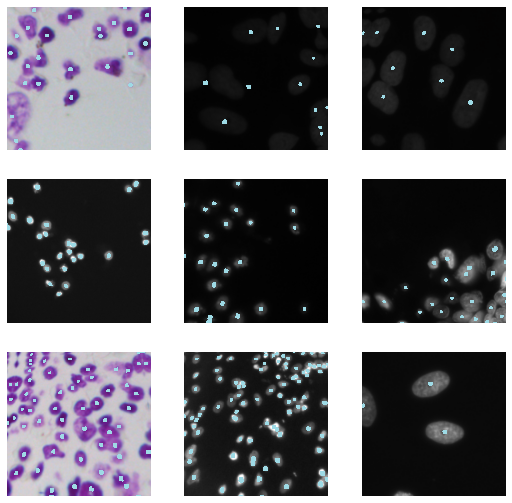

In [15]:
# currently augmentation transform screws with the padding
batch_tfms = [*aug_transforms(flip_vert=True), Normalize.from_stats(*imagenet_stats)]
# batch_tfms = []

sz_mthd = RandomCrop
# sz_mthd = Resize

dls = dsets.dataloaders(bs=16, after_item=[sz_mthd(256), ToTensor, IntToFloatTensor], after_batch=batch_tfms, num_workers=8)
dls.show_batch(cmap=cmap, vmin=0.01, vmax=1, alpha=1.0)

In [16]:
xb, yb = dls.one_batch()

In [17]:
dls.c = 2

## Learner

In [18]:

# name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Background']

def acc_nuclei(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_nuclei

In [20]:
# implementation here - https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8

class FocalLoss(nn.Module):
    
    def __init__(self, weight=None, 
                 gamma=2., reduction='none', axis=1):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.axis=axis
        
    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=self.axis)
        prob = torch.exp(log_prob)
        loss =  F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob, 
            target_tensor, 
            weight=self.weight,
            reduction = self.reduction
        )
        return loss.mean()

    def decodes(self, x):    
        return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [21]:
# loss_func = CrossEntropyLossFlat(axis=1)
weight = torch.tensor([1, 10])
loss_func = FocalLoss(weight=weight.float().cuda())

In [23]:
learn = unet_learner(dls, resnet34, metrics=metrics, loss_func=loss_func)
learn.path = DATA_PATH

In [22]:
learn.fit_one_cycle(60, slice(1e-2), wd=1e-4)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.162089,0.066976,0.624432,00:16
1,0.091318,0.054476,0.584090,00:13
2,0.065523,0.044560,0.722371,00:14
3,0.050831,0.039149,0.767128,00:13
4,0.042370,0.034432,0.795469,00:13
5,0.038410,0.038381,0.777198,00:13
6,0.036953,0.036534,0.834693,00:14
7,0.034882,0.033956,0.878303,00:13
8,0.033521,0.032544,0.884082,00:13
9,0.033285,0.031345,0.862698,00:13


In [23]:
learn.save('centernet_segmentation')

Path('models/centernet-256-focal_seg_2021-rerun.pth')

In [ ]:
learn.load('centernet_segmentation')

In [35]:
learn.fit_one_cycle(60, slice(1e-3), wd=1e-4)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.021859,0.024114,0.901153,00:14
1,0.022136,0.024345,0.897612,00:13
2,0.021967,0.024369,0.900233,00:13
3,0.021524,0.024737,0.893593,00:13
4,0.021661,0.024316,0.899897,00:12
5,0.021667,0.024425,0.899665,00:14
6,0.021929,0.024593,0.897158,00:12
7,0.021969,0.024143,0.902063,00:13
8,0.022020,0.024527,0.906240,00:14
9,0.021915,0.024724,0.893737,00:15


In [36]:
learn.save('centernet_segmentation')

Path('models/centernet-256-focal_seg_2021-rerun2.pth')

In [24]:
learn.load('centernet_segmentation')

In [25]:
import cv2
from functools import partial

def to_pts(box): # x,y,w,h -> x1,y1,x2,y2
    x,y,w,h = box
    return x,y,x+w,y+h

def score(box, pred): # get prediction score
    x1,y1,x2,y2 = box
    return pred[:, y1:y2,x1:x2].max()

def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

def euclidean_dist(boxA, boxB):
    def midpt(box):
        x1,y1,x2,y2 = box
        return (x1+x2)/2, (y1+y2)/2
    (xA,yA), (xB,yB) = midpt(boxA), midpt(boxB)
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

In [26]:
def bbox2center(bb):
    return torch.stack((bb[:,0]+bb[:,2]/2,bb[:,1]+bb[:,3]/2), -1)

In [25]:

def calc_pr(lbls, preds, pmaxs, min_sz=1, max_dist=5, iou_thresh=0.1, score_thresh=0.3):
    tps = []
    fps = []
    scores = []
    n_gts = []
    for lbl,pred,pmax in zip(lbls,preds,pmaxs):
        contours,hierarchy = cv2.findContours(pmax.max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pboxes = [cv2.boundingRect(cnt) for cnt in contours]
        pboxes = [to_pts(pbox) for pbox in pboxes if pbox[2] >= min_sz and pbox[3] >= min_sz] # only if width and height are greater than min_sz
        pboxes = [pbox for pbox in pboxes if score(pbox, pred) >= score_thresh]
        pboxes = list(sorted(pboxes, key=lambda x: score(x, pred), reverse=True)) # sort by scores
        

        contours,hierarchy = cv2.findContours((lbl>=0.9).max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        lboxes = [to_pts(cv2.boundingRect(cnt)) for cnt in contours]
        
#         detected = []
#         ious = []
#         for pb in pboxes:
#             calc = [(bb_iou(lb, pb), lb) for lb in lboxes if lb not in detected]
#             if len(calc) == 0: ious.append(0)
#             else:
#                 iou, lb = max(calc)
#                 detected.append(lb)
#                 ious.append(iou)
#         tp = (np.array(ious) >= iou_thresh)
#         fp = ~tp
#         s = np.array([score(pb, pred) for pb in pboxes])
                
        detected = []
        dists = []
        for pb in pboxes:
            calc = [(euclidean_dist(lb, pb), lb) for lb in lboxes if lb not in detected]
            if len(calc) == 0:
                dists.append(1e10)
            else:
                dist, lb = min(calc)
                detected.append(lb)
                dists.append(dist)
        tp = (np.array(dists) < max_dist)
        fp = ~tp
        s = np.array([score(pb, pred) for pb in pboxes])
            
        
        n_gts.append(len(lboxes))
        tps.extend(tp.astype(np.uint8).tolist())
        fps.extend(fp.astype(np.uint8).tolist())
        scores.extend(s.tolist())
        
    res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
    res = np.array(res)
    if len(res) == 0: res = np.zeros((1, 3))
    tp = res[:,1].cumsum(0)
    fp = res[:,2].cumsum(0)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / sum(n_gts)
    return precision, recall

In [26]:
preds, lbls = learn.get_preds()
preds = preds.detach().cpu().numpy()
lbls = lbls[:, None].detach().cpu().numpy()

In [29]:
for dist in [2, 5, 10]:
    aps = []
    for s in [5]:
        for sz in [2,4]:
            score_thresh = s/10
            pmaxs = preds.argmax(1)[:, None]
            
            precision, recall = calc_pr(lbls, preds, pmaxs, max_dist=dist, min_sz=sz, score_thresh=score_thresh)
            F1 = (2 * (precision * recall) / (precision + recall))[-1]
            aps.append((compute_ap(precision, recall), score_thresh, sz, F1))
    print(dist, max(aps))

2 (0.5489406341909479, 0.5, 2, 0.6421173762927441)
5 (0.7288790215800212, 0.5, 2, 0.7733026467181435)
10 (0.8246692555868711, 0.5, 2, 0.8285385500551538)


In [36]:
import matplotlib as mpl
cmap = mpl.cm.tab20
# cmap = mpl.cm.Dark2
cmap.set_under('k', 0.0)

<ipython-input-36-213f324b2de8>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  cmap.set_under('k', 0.0)


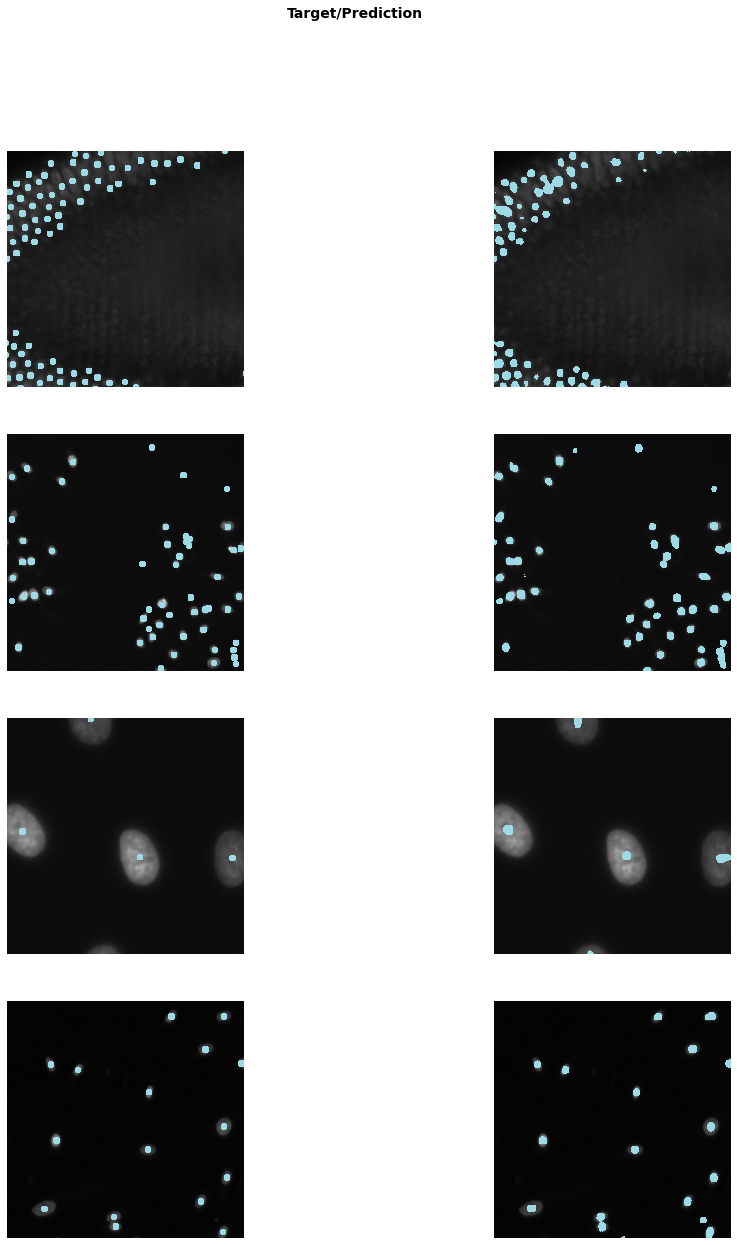

In [44]:
learn.show_results(figsize=(16,20), cmap=cmap, vmin=0.1, max_n=100, alpha=1.0, shuffle=True)

In [45]:
pmaxs.shape

(67, 1, 256, 256)

In [46]:
preds.shape

(67, 2, 256, 256)

## Below - calculates using max_px (similar to heatmap), however, it's better to calculate using centerpoint of boxes because segmentation doesn't have a good score distinction

In [29]:
preds, lbls = learn.get_preds()
preds = preds[:,1:].detach().cpu().numpy()
lbls = lbls[:, None].detach().cpu().numpy()

In [30]:
def max_px(box, targ):
    targ = targ[0]
    m = np.zeros_like(targ)
    y,x,h,w = box
    m[x:x+w,y:y+h] = 1
    ind = np.unravel_index(np.argmax(targ*m, axis=None), targ.shape)
    return ind

def ed(pt1, pt2):
    (xA,yA), (xB,yB) = pt1, pt2
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

def calc_pr_area(lbls, preds, pmaxs, min_area=8, max_dist=5, iou_thresh=0.1, score_thresh=0.3):
    tps = []
    fps = []
    scores = []
    n_gts = []
    for lbl,pred,pmax in zip(lbls,preds,pmaxs):
        contours,hierarchy = cv2.findContours(pmax.max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= min_area]
        pboxes = [max_px(pbox, pred) for pbox in pboxes]
        pboxes = list(sorted(pboxes, key=lambda x: pred[0][x], reverse=True)) # sort by scores

        contours,hierarchy = cv2.findContours((lbl>=0.9).max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        lboxes = [max_px(cv2.boundingRect(cnt), lbl) for cnt in contours]
                
        detected = []
        dists = []
        for pb in pboxes:
            calc = [(ed(lb, pb), lb) for lb in lboxes if lb not in detected]
            if len(calc) == 0:
                dists.append(1e10)
            else:
                dist, lb = min(calc)
                detected.append(lb)
                dists.append(dist)
        tp = (np.array(dists) < max_dist)
        fp = ~tp
        s = np.array([pred[0, pb[0],pb[1]] for pb in pboxes])
            
        
        n_gts.append(len(lboxes))
        tps.extend(tp.astype(np.uint8).tolist())
        fps.extend(fp.astype(np.uint8).tolist())
        scores.extend(s.tolist())
        
    res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
    res = np.array(res)
    if len(res) == 0: res = np.zeros((1, 3))
    tp = res[:,1].cumsum(0)
    fp = res[:,2].cumsum(0)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / sum(n_gts)
    return precision, recall

for dist in [2, 5, 10]:
    aps = []
    for s in [2, 5, 8]:
        for sz in [1,2,4]:
            score_thresh = s/10
            pmaxs = (preds > score_thresh).astype(np.uint8)

            precision, recall = calc_pr_area(lbls, preds, pmaxs, max_dist=dist, min_area=sz, score_thresh=score_thresh)
            aps.append((compute_ap(precision, recall),score_thresh,sz))
    print(dist, max(aps))

2 (0.00047914750854922923, 0.5, 4)
5 (0.6652529843973373, 0.5, 1)
10 (0.8227580193808449, 0.5, 1)
